# Sesgos a la hora de acceder a créditos bancarios - German Credit Dataset

El siguiente notebook tiene como objetivo desarrollar un modelo de aprendizaje automático para poner en práctica conceptos de fairness y usar las herramientas que permiten trabajar en este ámbito.

Para eso tomaremos [un conjunto de datos](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) que se utiliza comúnmente en la literatura sobre equidad crediticia. Contiene información sobre 1000 solicitantes de préstamos e incluye 20 atributos que describen a cada solicitante, como su historial crediticio, el propósito del préstamo, el monto solicitado, el estado civil, el género, la edad, el empleo y la situación de la vivienda. También incluye un atributo adicional que describe el resultado de la clasificación: si el solicitante tiene una calificación crediticia buena o mala.

## Vista Inicial a los datos

### Carga + preprocesamiento previo

Primero empezamos por hacer la lectura inicial al conjunto de datos 'german.data' que según la fuente contiene la información en datos de tipo categórico y numérico:

In [1]:
import pandas as pd
import os 

ruta_archivo = os.path.join('..', 'data', 'raw', 'german.data')

df = pd.read_csv(ruta_archivo, sep=' ', header=None, skipinitialspace=True)

In [2]:
df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


Podemos ver que el conjunto de datos en su versión inicial no está muy legible de cara a un EDA, por lo tanto voy a generar otro conjunto de datos con sus atributos legibles y nombres de columnas
identificados. Para hacer eso me voy a basar en la documentación de los atributos disponible en la fuente.

In [ ]:
# Armo una lista con los nombres de las columnas según la fuente
nombres_columnas = [
    "checking_account", "duration", "credit_history", "purpose", "credit_amount",
    "savings_account", "employment_since", "installment_rate", "personal_status_sex",
    "other_debtors", "residence_since", "property", "age", "other_installment_plans",
    "housing", "number_credits", "job", "people_liable", "telephone", "foreign_worker",
    "target"
]
df.columns = nombres_columnas

# Armo un diccionario que mapee a las variables categóricas con el valor que representan
mapeos = {
    "checking_account": {
        "A11": "< 0 DM",
        "A12": "0 <= ... < 200 DM",
        "A13": ">= 200 DM or salary assigned",
        "A14": "no account"
    },
    "credit_history": {
        "A30": "no credits / all paid",
        "A31": "paid at this bank",
        "A32": "paid duly till now",
        "A33": "delay in past",
        "A34": "critical account / other bank"
    },
    "purpose": {
        "A40": "car (new)",
        "A41": "car (used)",
        "A42": "furniture/equipment",
        "A43": "radio/TV",
        "A44": "domestic appliances",
        "A45": "repairs",
        "A46": "education",
        "A47": "vacation?",
        "A48": "retraining",
        "A49": "business",
        "A410": "others"
    },
    "savings_account": {
        "A61": "< 100 DM",
        "A62": "100 <= ... < 500 DM",
        "A63": "500 <= ... < 1000 DM",
        "A64": ">= 1000 DM",
        "A65": "unknown / no account"
    },
    "employment_since": {
        "A71": "unemployed",
        "A72": "< 1 year",
        "A73": "1 <= ... < 4 years",
        "A74": "4 <= ... < 7 years",
        "A75": ">= 7 years"
    },
    "personal_status_sex": {
        "A91": "male, divorced/separated",
        "A92": "female, div/sep/married",
        "A93": "male, single",
        "A94": "male, married/widowed",
        "A95": "female, single"
    },
    "other_debtors": {
        "A101": "none",
        "A102": "co-applicant",
        "A103": "guarantor"
    },
    "property": {
        "A121": "real estate",
        "A122": "building society / insurance",
        "A123": "car / other",
        "A124": "unknown / no property"
    },
    "other_installment_plans": {
        "A141": "bank",
        "A142": "stores",
        "A143": "none"
    },
    "housing": {
        "A151": "rent",
        "A152": "own",
        "A153": "for free"
    },
    "job": {
        "A171": "unemployed / non-resident",
        "A172": "unskilled - resident",
        "A173": "skilled / official",
        "A174": "management / self-employed / qualified"
    },
    "telephone": {
        "A191": "none",
        "A192": "yes, registered"
    },
    "foreign_worker": {
        "A201": "yes",
        "A202": "no"
    }
}

df_legible = df.copy()

# Aplico los mapeos
for col, mapeo in mapeos.items():
    df_legible[col] = df_legible[col].map(mapeo)

# Ahora miro a un df legible
df_legible.head()

,checking_account,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,target
0,< 0 DM,6,critical account / other bank,radio/TV,1169,unknown / no account,>= 7 years,4,"male, single",none,...,real estate,67,none,own,2,skilled / official,1,"yes, registered",yes,1
1,0 <= ... < 200 DM,48,paid duly till now,radio/TV,5951,< 100 DM,1 <= ... < 4 years,2,"female, div/sep/married",none,...,real estate,22,none,own,1,skilled / official,1,none,yes,2
2,no account,12,critical account / other bank,education,2096,< 100 DM,4 <= ... < 7 years,2,"male, single",none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,1
3,< 0 DM,42,paid duly till now,furniture/equipment,7882,< 100 DM,4 <= ... < 7 years,2,"male, single",guarantor,...,building society / insurance,45,none,for free,1,skilled / official,2,none,yes,1
4,< 0 DM,24,delay in past,car (new),4870,< 100 DM,1 <= ... < 4 years,3,"male, single",none,...,unknown / no property,53,none,for free,2,skilled / official,2,none,yes,2


Como último paso de este preprocesamiento previo voy a hacer un nuevo atributo 'target_label' que mapee los valores 1 y 2 a 'good' y 'bad'. Esto para hacer más ameno el análisis exploratorio de la variable objetivo:

In [ ]:
# Mapear target a etiquetas legibles
df_legible['target_label'] = df_legible['target'].map({1: 'good', 2: 'bad'})

Ahora podemos usar este "df_legible" para hacer un análisis exploratorio adecuado y verificar la estructura de los datos.

### Verificación de estructura de los datos

Antes de proceder con el EDA siempre es buena práctica mirar si hay valores faltantes en el conjunto de datos, que los tipos sean los correctos y que las columnas sean las esperadas:

In [ ]:
df_legible.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account         1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   object
 6   employment_since         1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  residence_since          1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

Podemos ver que todo está bien, tenemos 1000 registros y todas las columnas especificadas en la fuente de los datos están presentes. Lo único que queda hacer es cambiar los tipos de datos de las
columnas categóricas de 'object' a 'category' para hacer un EDA adecuadamente:

In [ ]:
# Convierto los tipo object a category
atributos_categoricos = df_legible.select_dtypes(include=['object']).columns
df_legible[atributos_categoricos] = df_legible[atributos_categoricos].astype('category')

# Verifico que los tipos de datos sean correctos
df_legible.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   checking_account         1000 non-null   category
 1   duration                 1000 non-null   int64   
 2   credit_history           1000 non-null   category
 3   purpose                  1000 non-null   category
 4   credit_amount            1000 non-null   int64   
 5   savings_account          1000 non-null   category
 6   employment_since         1000 non-null   category
 7   installment_rate         1000 non-null   int64   
 8   personal_status_sex      1000 non-null   category
 9   other_debtors            1000 non-null   category
 10  residence_since          1000 non-null   int64   
 11  property                 1000 non-null   category
 12  age                      1000 non-null   int64   
 13  other_installment_plans  1000 non-null   category
 14  housing  

Ahora sí que todo está bien podemos proceder con el EDA.

## EDA

### Variables numéricas

Como primera parte de este análisis exploratorio vamos a empezar a analizar a las variables numéricas presentes en el conjunto de datos. Como primer acercamiento siempre es bueno usar la función ".describe()":

In [ ]:
df_legible.describe()

,duration,credit_amount,installment_rate,residence_since,age,number_credits,people_liable,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


Por ahora no hay nada fuera de lugar, podemos notar cosas como:

* La mediana de la duración de un préstamo es de 18 meses.
* La mediana de la edad de un solicitante de préstamo es de 33 años.
* En un caso promedio un solicitante tiene un solo crédito activo en el banco pero puede extenderse hasta a 4 en un caso máximo.
* Lo común es que los solicitantes tengan bajo riesgo crediticio.

Ahora pasaremos a ver gráficos de caja que nos ayuden a ver como se distribuyen estas variables respecto a la variable objetivo:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

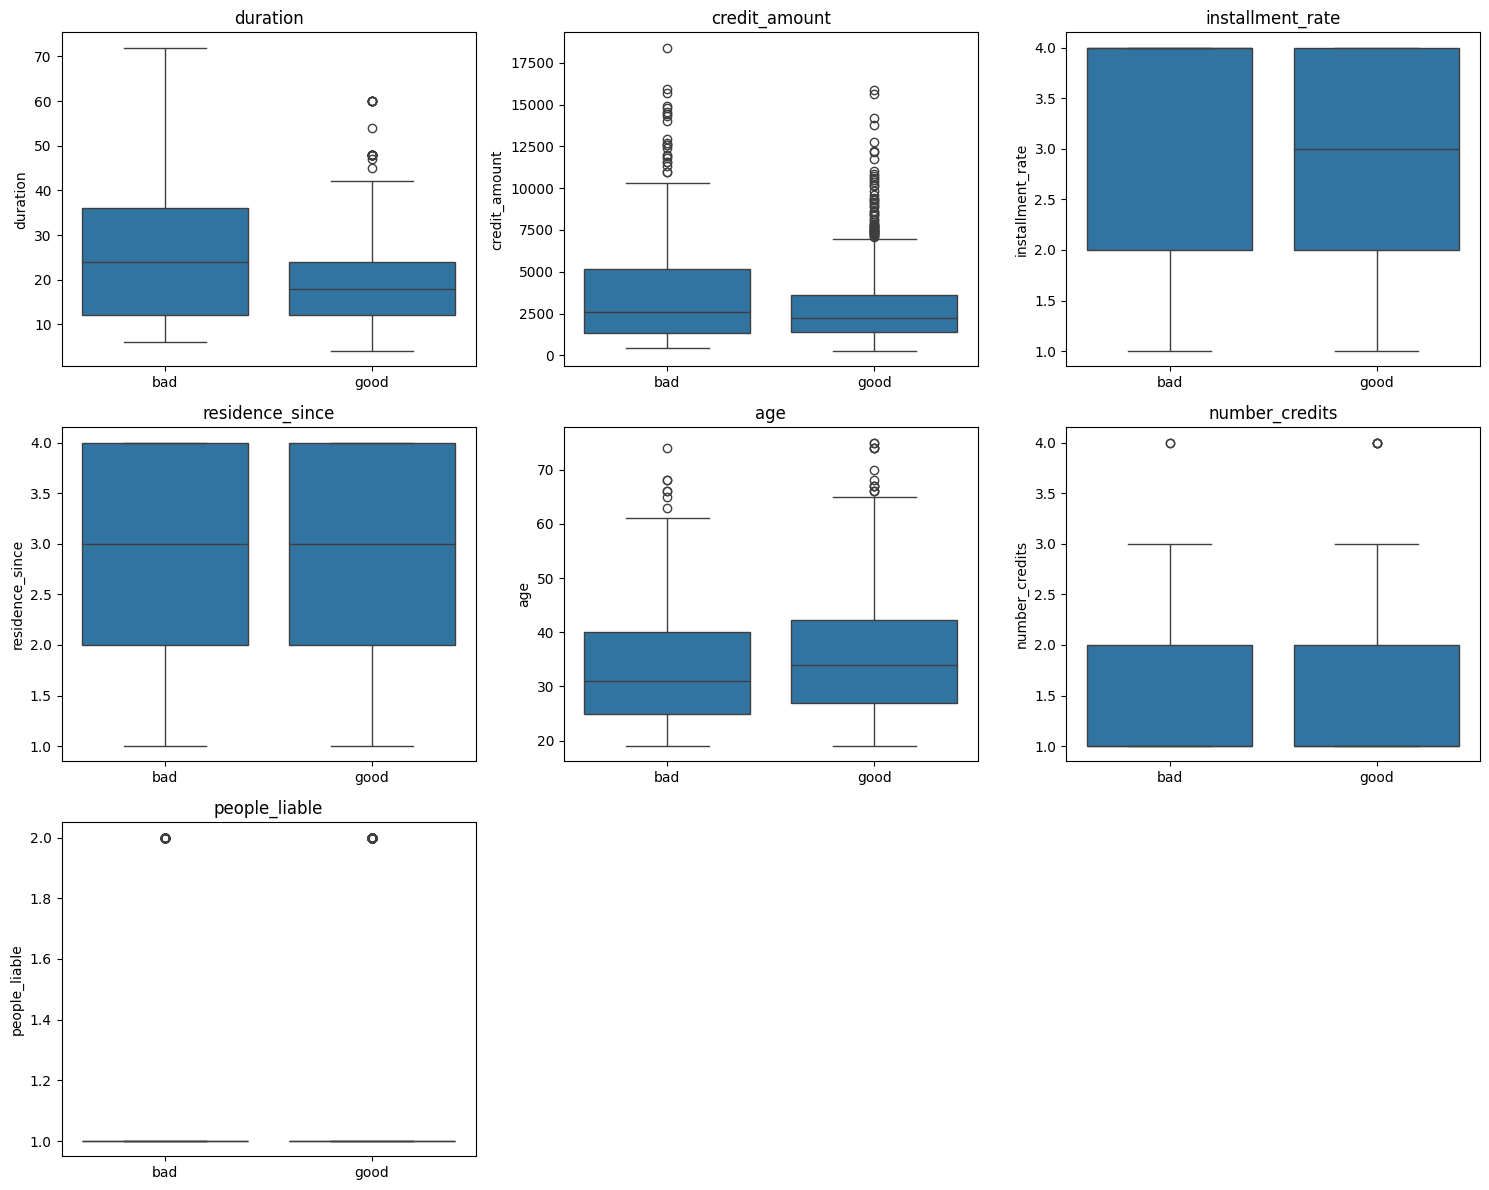

In [ ]:
num_vars = ['duration', 'credit_amount', 'installment_rate', 'residence_since',
            'age', 'number_credits', 'people_liable']

n = len(num_vars)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))

for i, col in enumerate(num_vars):
    r, c = divmod(i, cols)
    ax = axes[r][c] if rows > 1 else axes[c]
    sns.boxplot(data=df_legible, x='target_label', y=col, ax=ax)
    ax.set_title(f"{col}")
    ax.set_xlabel('')
    ax.set_ylabel(col)

for j in range(n, rows * cols):
    r, c = divmod(j, cols)
    ax = axes[r][c] if rows > 1 else axes[c]
    ax.axis('off')

plt.tight_layout()
plt.show()

De estos gráficos de caja podemos sacar algunas observaciones:

* Entre los solicitantes que fueron clasificados con alto riesgo crediticio, los préstamos que solicitaron tuvieron una mediana de duración mayor que aquellos préstamos pertenecientes a personas clasificadas con bajo riesgo crediticio.

* Aunque tienen una mediana similar, el monto del préstamo tiende a ser ligeramente mayor en aquellos solicitantes que fueron clasificados con alto riesgo.

* La mediana de edad de aquellos que fueron clasificados como solicitantes de bajo riesgo es mayor a la de aquellos que fueron clasificados con alto riesgo.

Un último aspecto que resulta interesante observar con las variables numéricas es una matriz de correlación. Con esto podremos identificar aquellas variables que se muestren correlacionadas con la variable objetivo:

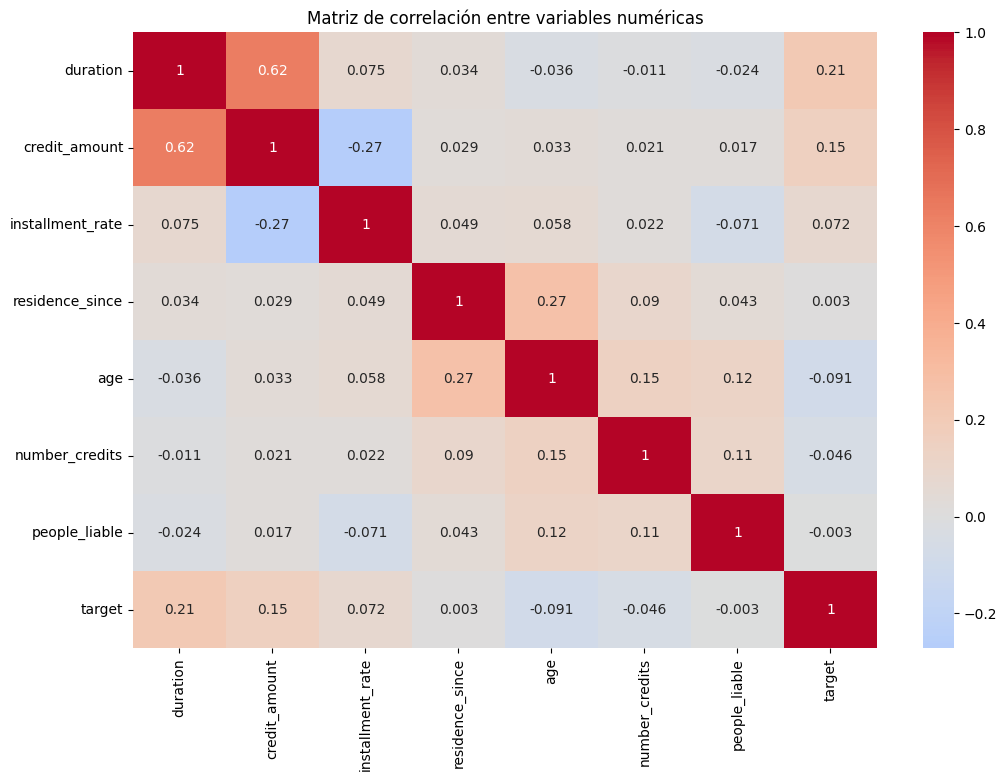

In [ ]:
lista_matriz = num_vars + ['target']

corr_matrix = df_legible[lista_matriz].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

De esta matriz podemos ver que en general las correlaciones entre variables son débiles tanto en el sentido positivo como negativo. Sin embargo hay detalles que podemos destacar:

* La duración del préstamo resultó ser la variable con mayor correlación con la variable objetivo, esto tiene sentido con lo observado anteriormente en los gráficos de caja.

* Por otro lado el monto del préstamo también resultó ser una de las variables con más correlación con la variable objetivo, confirmando también lo observado en los gráficos de caja.

Fuera de estos puntos vemos que no existen más correlaciones a destacar entre las variables numéricas.

Con este análisis sobre las variables numéricas obtuvimos un mejor entendimiento de la información que tenemos, ahora como siguiente paso analizaremos a las variables categóricas.

### Variables categóricas

Ahora continuando este análisis exploratorio vamos a analizar a las variables categóricas presentes en el conjunto de datos. De vuelta, como primer acercamiento siempre es bueno usar la función ".describe()" pero ahora enfocado en variables categóricas:

In [ ]:
df_legible.describe(include='category')

,checking_account,credit_history,purpose,savings_account,employment_since,personal_status_sex,other_debtors,property,other_installment_plans,housing,job,telephone,foreign_worker,target_label
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,4,5,10,5,5,4,3,4,3,3,4,2,2,2
top,no account,paid duly till now,radio/TV,< 100 DM,1 <= ... < 4 years,"male, single",none,car / other,none,own,skilled / official,none,yes,good
freq,394,530,280,603,339,548,907,332,814,713,630,596,963,700


Esta función, si lo pensamos en ese sentido, nos muestra las características cualitativas del "solicitante promedio" de un préstamo en el banco. A partir de esto podemos resaltar algunos puntos:

* Al momento de solicitar un préstamo, un solicitante suele tener todos sus préstamos pagados debidamente.
* Los solicitantes son mayormente hombres solteros.
* Los solicitantes en gran mayoría son dueños de la casa que habitan.
* Los solicitantes en gran mayoría tienen trabajos estables.
* La mayoría son trabajadores extranjeros.
* Y como habíamos visto en los gráficos de caja anteriormente, la mayoría de los solicitantes tienen un bajo riesgo crediticio.

Ahora y al igual que hicimos con las variables numéricas vamos a observar como se distribuyen las variables categóricas respecto de la variable objetivo haciendo uso en este caso de gráficos de barra.

Una aclaración importante es que para este conjunto de gráficos voy a dejar afuera a la variable que registra datos sobre el género del solicitante ya que esta es nuestro foco principal y será dejado para un análisis a profundidad posterior a este.

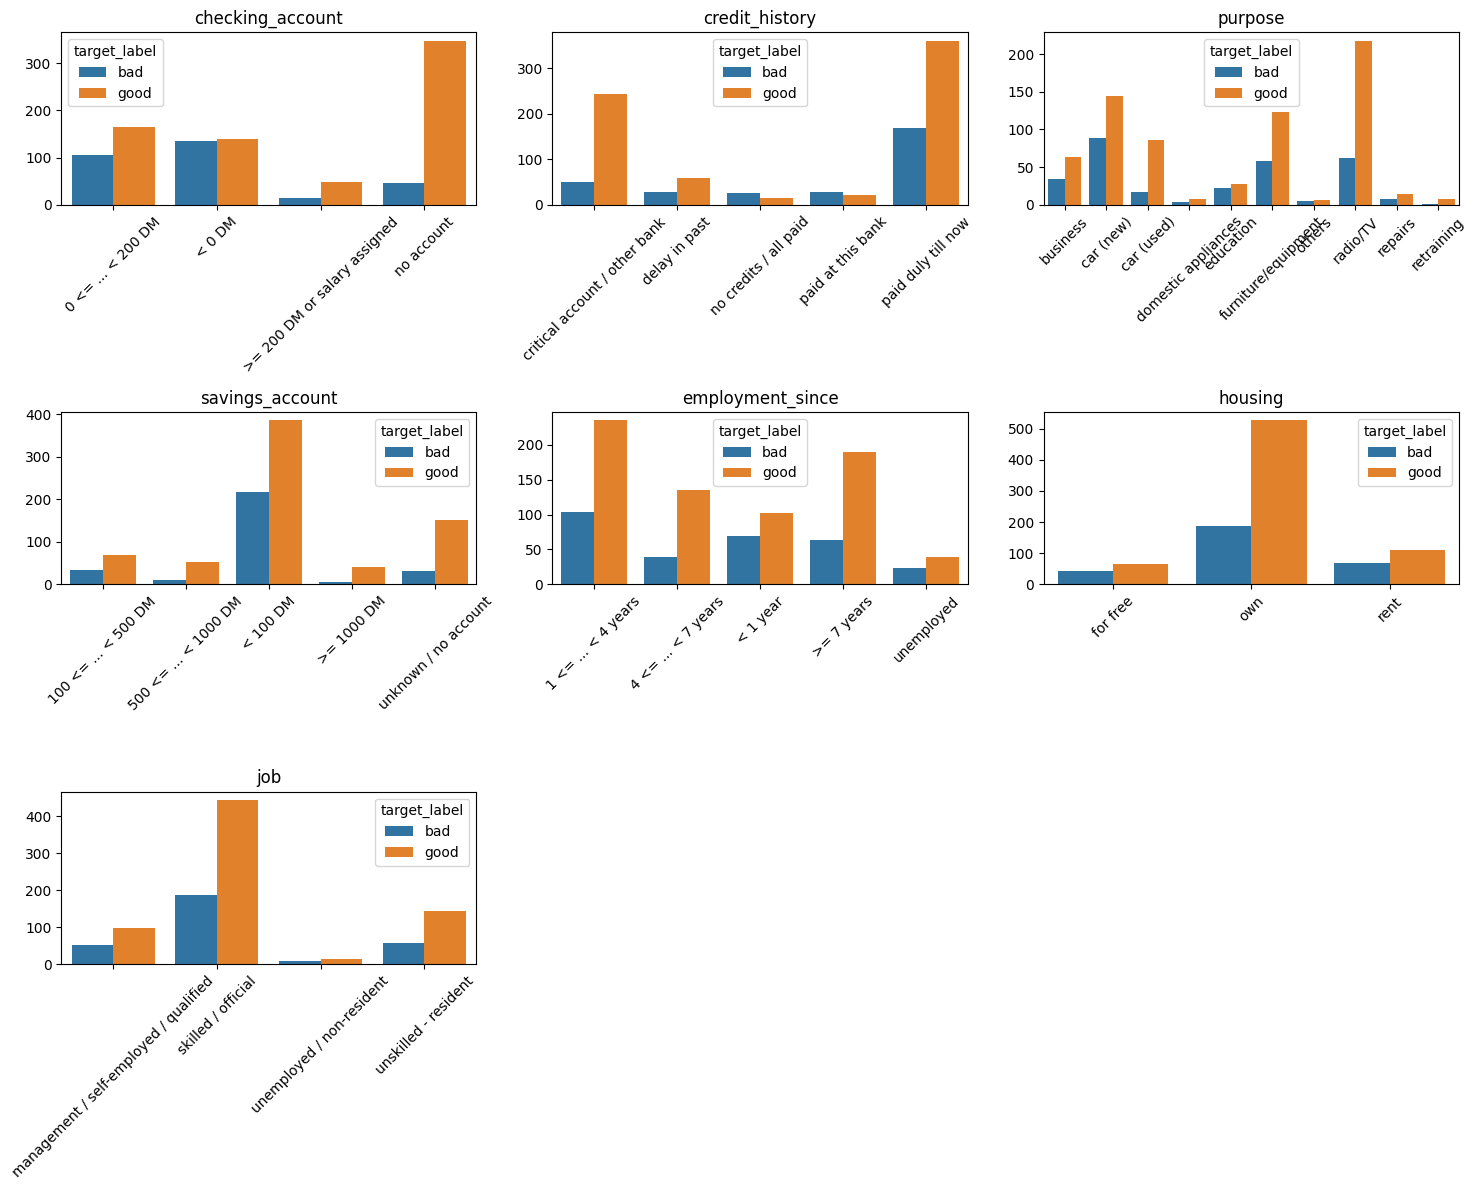

In [ ]:
cat_vars = ['checking_account', 'credit_history', 'purpose', 'savings_account',
            'employment_since', 'housing', 'job']

n = len(cat_vars)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))

for i, col in enumerate(cat_vars):
    r, c = divmod(i, cols)
    ax = axes[r][c] if rows > 1 else axes[c]
    sns.countplot(data=df_legible, x=col, hue='target_label', ax=ax)
    ax.set_title(f"{col}")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)

# Si sobran ejes, los desactivo
for j in range(n, rows * cols):
    r, c = divmod(j, cols)
    ax = axes[r][c] if rows > 1 else axes[c]
    ax.axis('off')

plt.tight_layout()
plt.show()

De estos gráficos sacamos conclusiones más o menos similares a las que sacamos cuando usamos ".describe()", pero con algunos detalles más acerca de aquellos solicitantes clasificados como de alto riesgo:

* Los solicitantes de bajo riesgo suelen no tener cuenta o tener saldos altos. Los de alto riesgo se concentran con saldos bajos.

* En solicitantes con ahorros más bajos (<100 DM) suelen aparecer más de alto riesgo.

* Mayor antigüedad (≥ 4 años) se asocia a buen historial. Los que llevan menos de 1 año o están desempleados tienden a ser de alto riesgo.

* La mayoría de los solicitantes de bajo riesgo son propietarios. Alquilar o vivir gratis es más común entre aquellos solicitantes clasificados como de alto riesgo.

Con todos estos puntos en mente ya tenemos un análisis realizado sobre las variables presentes en nuestro conjunto de datos, logrando identificar aquellas más relevantes para la variable objetivo y aquellas que no tanto.

Ahora como último paso en este análisis exploratorio analizaremos un poco a profundidad a la variable que registra información sobre el género del solicitante.

### Enfocándonos en el género

Ahora entramos en la parte final del EDA que consistirá básicamente en inspeccionar a la variable que registra información sobre el género "a profundidad".

Para esto voy a generar una nueva variable 'genre' en el conjunto de datos y así poder analizar solo dos categorías: 'male' y 'female'. De este modo considero que tendremos un vistazo más certero sobre el comportamiento de la variable objetivo respecto a estas categorías.

In [ ]:
df_legible['genre'] = None

df_legible.loc[df_legible['personal_status_sex'].str.contains('male'), 'genre'] = 'male'
df_legible.loc[df_legible['personal_status_sex'].str.contains('female'), 'genre'] = 'female'

Empecemos por ver la cantidad de solicitantes en cada grupo:

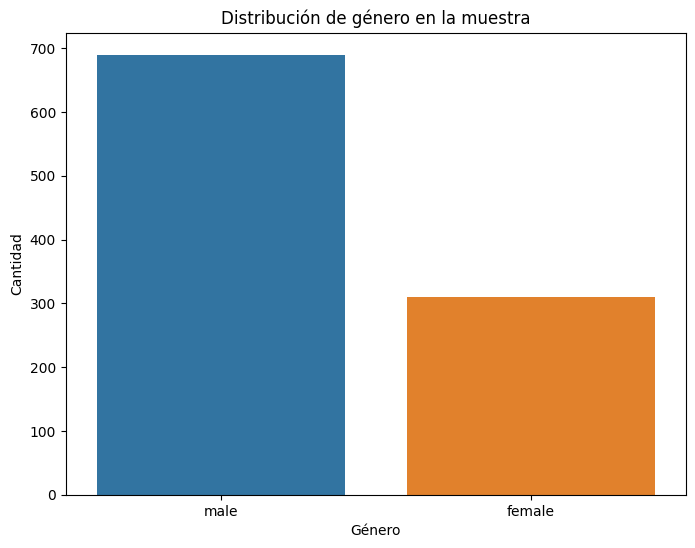

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_legible, x='genre', hue= 'genre')
plt.title("Distribución de género en la muestra")
plt.xlabel("Género")
plt.ylabel("Cantidad")
plt.show()

Tenemos una clara mayoría del género masculino siendo en total 700 solicitantes de este género ante 300 del género femenino.

Veamos ahora estas cantidades respecto de la variable objetivo:

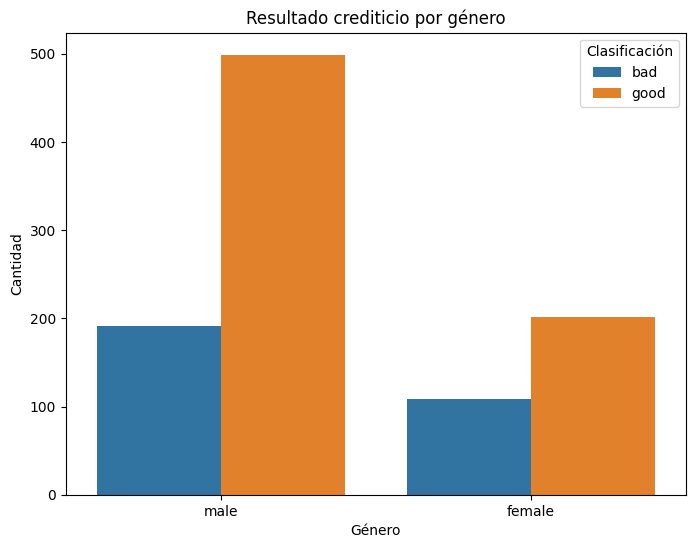

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_legible, x='genre', hue='target_label')
plt.title("Resultado crediticio por género")
plt.xlabel("Género")
plt.ylabel("Cantidad")
plt.legend(title="Clasificación")
plt.show()

Podemos ver que en el género femenino la diferencia de proporciones entre el bajo o alto riesgo crediticio no está tan marcada como en el género masculino, donde la mayoría son clasificados como de bajo riesgo. Esto nos deja que en términos de proporciones, a las solicitantes femeninas se les suele clasificar como de alto riesgo.

Veamos esto de las proporciones con un gráfico:

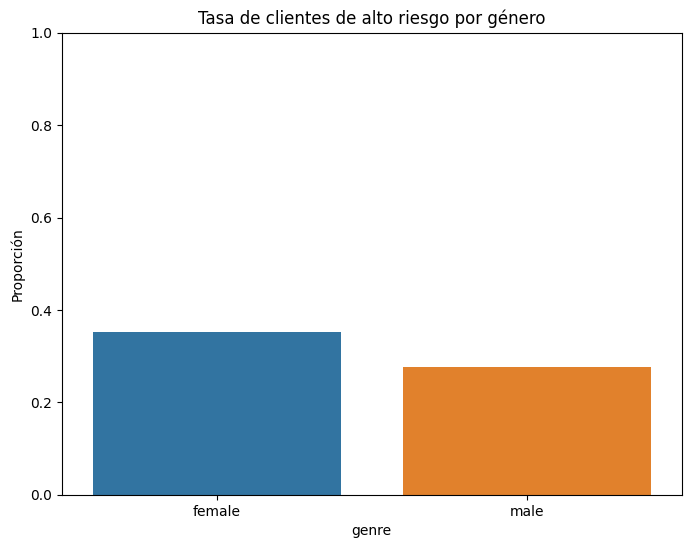

In [ ]:
tasa_genero = df_legible.groupby('genre')['target'].apply(lambda x: (x == 2).mean()).reset_index()
tasa_genero.columns = ['genre', 'tasa']

plt.figure(figsize=(8, 6))
sns.barplot(data=tasa_genero, x='genre', y='tasa', hue='genre')
plt.title("Tasa de clientes de alto riesgo por género")
plt.ylabel("Proporción")
plt.ylim(0, 1)
plt.show()

In [ ]:
tasa_genero

,genre,tasa
0,female,0.351613
1,male,0.276812


A partir del gráfico y mirando la tabla más arriba podemos ver que los solicitantes clasificados como de alto riesgo en mayor parte son femeninos (cosa que ya habíamos notado en los gráficos anteriores). Más precisamente tenemos que la diferencia es de 8 puntos entre géneros.

Considerar estos puntos es clave de cara a la construcción del modelo y evaluación de equidad sobre el mismo. ¿Será que existe un sesgo preestablecido entre las personas que generaron la clasificación originalmente?, ¿podremos evitar ese sesgo en el modelo?.

## Entrenando un primer modelo

### Carga de datos en formato numérico

Ahora llegamos a la parte en la que vamos a construir un primer modelo. Para esto voy a cargar un conjunto de datos que se encuentra en la fuente que representa al mismo que exploramos antes pero fue llevado a valores numéricos para poder entrenar modelos con él.

En este nuevo conjunto de datos aparecen más columnas que intuyo provienen de algún one hot encoding o alguna técnica relacionada pero en principio no tenemos forma de identificar las columnas más que comparar algunos valores. Por lo tanto voy a considerar a este conjunto de datos en su completitud para entrenar al modelo.

Lo ideal sería hacer una selección de features considerando la exploración que hicimos antes y empezar desde un modelo más simple, pero a efectos prácticos de este análisis de fairness voy a utilizar el conjunto de datos numérico tal como está.

In [ ]:
df_numeric = pd.read_csv('./drive/MyDrive/German_data_equidad/german.data-numeric', sep=' ', header=None, skipinitialspace=True)

In [ ]:
df_numeric.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,6,4,12,5,5,3,4,1,67,...,0,1,0,0,1,0,0,1,1,NaN
1,2,48,2,60,1,3,2,2,1,22,...,0,1,0,0,1,0,0,1,2,NaN
2,4,12,4,21,1,4,3,3,1,49,...,0,1,0,0,1,0,1,0,1,NaN
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,1,1,NaN
4,1,24,3,49,1,3,3,4,4,53,...,0,1,0,0,0,0,0,1,2,NaN


Podemos ver que la última columna tiene valores faltantes, usemos la función ".info()" de pandas para ver si esto se extiende a lo largo de la columna:

In [ ]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   int64  
 1   1       1000 non-null   int64  
 2   2       1000 non-null   int64  
 3   3       1000 non-null   int64  
 4   4       1000 non-null   int64  
 5   5       1000 non-null   int64  
 6   6       1000 non-null   int64  
 7   7       1000 non-null   int64  
 8   8       1000 non-null   int64  
 9   9       1000 non-null   int64  
 10  10      1000 non-null   int64  
 11  11      1000 non-null   int64  
 12  12      1000 non-null   int64  
 13  13      1000 non-null   int64  
 14  14      1000 non-null   int64  
 15  15      1000 non-null   int64  
 16  16      1000 non-null   int64  
 17  17      1000 non-null   int64  
 18  18      1000 non-null   int64  
 19  19      1000 non-null   int64  
 20  20      1000 non-null   int64  
 21  21      1000 non-null   int64  
 22  2

Vemos que es una columna vacía, por lo tanto simplemente la eliminamos:

In [ ]:
# eliminamos la última columna
df_numeric = df_numeric.iloc[:, :-1]

### Entrenamiento del modelo

Ahora la idea es entrenar un modelo de aprendizaje automático y dada la forma de nuestra variable objetivo lo más sensato es utilizar un modelo de regresión logística, aunque podríamos usar otro tipo de modelos más complejos.

En este caso elijo usar a la regresión logística por su simpleza en términos de implementación y facilidad para ser interpretado, lo que a su vez facilita el análisis de equidad.

Empiezo por separar en matriz de diseño y variable objetivo y hacer un mapeo de los valores de la variable objetivo para que estos estén representados en términos de 0 y 1.

* 0 -> Bajo riesgo crediticio
* 1 -> Alto riesgo crediticio

In [ ]:
X = df_numeric.iloc[:, :-1]
y = df_numeric.iloc[:, -1].map({1: 0, 2: 1})
indices = X.index

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X.values, y.values, indices, test_size=0.2, random_state=42)

# Agrego intercepto
X_train_design = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_design = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

In [ ]:
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

def neg_log_likelihood(beta, X, y):
    nu = X @ beta
    vinculo = sigmoide(nu)
    return -np.sum(y * np.log(vinculo + 1e-10) + (1 - y) * np.log(1 - vinculo + 1e-10))

In [ ]:
from scipy.optimize import minimize

# Inicializamos coeficientes
initial_beta = np.zeros(X_train_design.shape[1])

# Ajuste con minimize
res = minimize(neg_log_likelihood, initial_beta, args=(X_train_design, y_train), method='BFGS')

# Coeficientes resultantes
beta_hat = res.x

In [ ]:
beta_hat

array([ 3.88049067, -0.54589779,  0.02723487, -0.38685489,  0.00560824,
       -0.16011435, -0.1460473 , -0.17843473,  0.03459702,  0.15777867,
       -0.0244037 , -0.34413083,  0.2964565 ,  0.02209763, -0.2104713 ,
       -1.33135742,  0.72477767, -0.89810282,  0.84817875,  0.74543736,
        0.06232551, -0.4395021 , -0.92887852, -0.23123497, -0.06263938])

In [ ]:
y_pred_probs = sigmoide(X_test_design @ beta_hat)

y_pred = (y_pred_probs >= 0.5).astype(int)

Ahora con un modelo entrenado y predicciones realizadas no queda más que hacer un análisis de las métricas del modelo.

### Mirando las métricas del modelo

Ahora seguimos con la evaluación de las distintas métricas del modelo en general usando el conjunto de test. Para empezar voy a generar un reporte de clasificación que acumule métricas varias:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       141
           1       0.66      0.53      0.58        59

    accuracy                           0.78       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200



Podemos ver que en general el modelo tiene un buen desempeño identificando a los solicitantes de bajo riesgo mientras que su desempeño cae al identificar a los solicitantes de alto riesgo. Podemos suponer inicialmente que esto es debido al desequilibrio entre ambas categorías pero pueden haber otros motivos.

Si lo comparamos con los modelos que indica la fuente que fueron entrenados con estos datos, esta regresión logística entra dentro del rango en términos de precision y accuracy para modelos de su mismo tipo.

Ahora generemos una matriz de confusión para ver el desempeño del modelo identificando instancias:

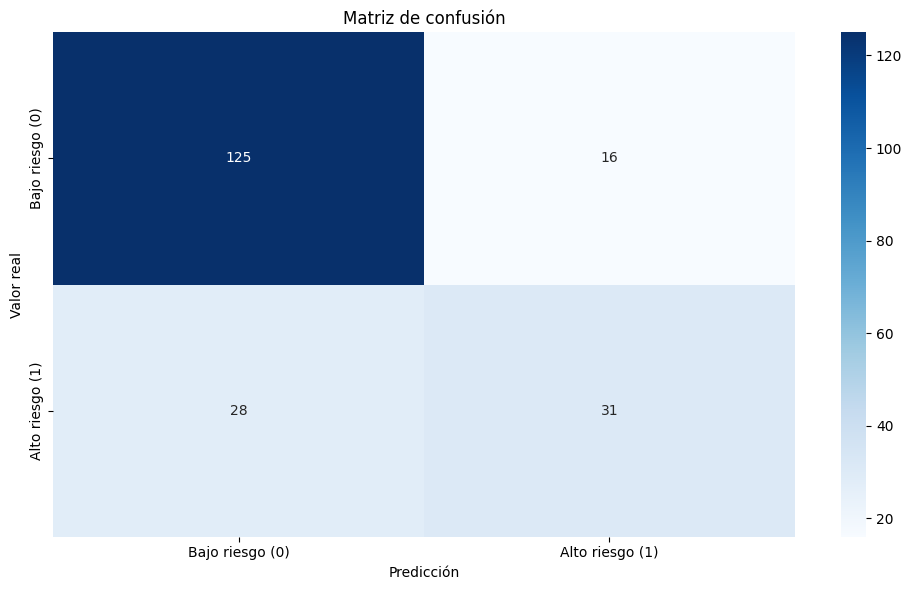

In [ ]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Bajo riesgo (0)', 'Alto riesgo (1)']

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión')
plt.tight_layout()
plt.show()

Para leer esta matriz de confusión tenemos que considerar:

* Los verdaderos positivos son los solicitantes que fueron clasificados de bajo riesgo por el modelo y que en la realidad también tenían la misma clasificación.
* Los verdaderos negativos son los solicitantes que fueron clasificados de alto riesgo por el modelo y que en la realidad también tenían la misma clasificación.
* Los falsos positivos son los solicitantes que fueron clasificados de bajo riesgo por el modelo y que en la realidad fueron clasificados como de alto riesgo.
* Los falsos negativos son los solicitantes que fueron clasificados de alto riesgo por el modelo y que en la realidad fueron clasificados como de bajo riesgo.

Dejando esto en claro podemos remarcar los siguientes puntos:

*  El modelo logró identificar correctamente en la mayoría de los casos a los solicitantes de bajo riesgo con un total de 125 verdaderos positivos.

* Podemos notar que también tuvo varios casos de falsos positivos con 28 en total, esto representa al tipo de error que para ojos del banco es más grave ya que son solicitantes a los cuales se les otorgaría un préstamo y son realmente de alto riesgo crediticio.

* Luego tuvo 16 casos de falsos negativos que si bien es un error no es tan grave como el mencionado anteriormente, además que no es un número alarmante.

* Logró identificar correctamente a 31 solicitantes de alto riesgo pero es un número que podría mejorar.

Con este análisis en general del modelo ahora podemos pasar a hacer algo similar pero separando por género del solicitante, esto nos permitirá empezar a analizar aspectos de la equidad presente en este modelo e identificar potenciales sesgos.

## Mirando la equidad por género

### Mirando matriz de confusión y métricas varias

Ahora vamos a analizar al atributo que consideramos sensible en este análisis, el género. Para esto voy a separar el conjunto de datos de test entre la categoría femenina y masculina, además de que voy a quedarme solo con las columnas relevantes para esta evaluación:

In [ ]:
fairness_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'genre': df_legible.loc[idx_test, 'genre']
})

In [ ]:
fairness_df

,y_test,y_pred,genre
521,1,1,female
737,0,1,male
740,0,1,male
660,0,0,male
411,0,0,male
...,...,...,...
408,0,0,male
332,1,1,female
208,0,1,male
613,0,0,female


In [ ]:
fairness_df_male = fairness_df[fairness_df['genre'] == 'male']
fairness_df_female = fairness_df[fairness_df['genre']  == 'female']

Con los grupos separados lo siguiente es armar una matriz de confusión para cada uno, así podremos tener insights más precisos sobre el comportamiento del modelo con ambos grupos:

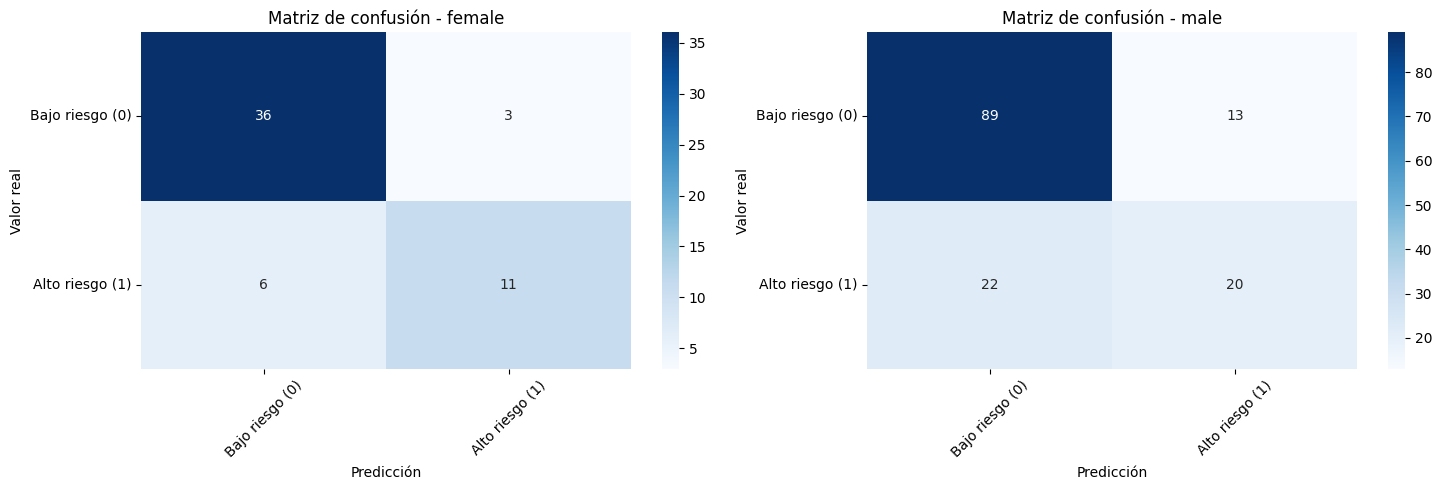

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

dfs = [fairness_df_female, fairness_df_male]

for ax, df in zip(axes, dfs):
    cm = confusion_matrix(df['y_test'], df['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Valor real')
    ax.set_title(f'Matriz de confusión - {df["genre"].iloc[0]}')
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels, rotation=0)
plt.tight_layout()

De este par de gráficos podemos notar lo siguiente:

* En ambas categorías el modelo logró identificar en la mayoría de los casos a los verdaderos positivos con 36 casos en la categoría femenina y 89 en la masculina.

* En la categoría masculina se obtuvo una mayor tasa de falsos positivos en términos de proporción a comparación de la categoría femenina, siendo que de un total de 42 casos de alto riesgo, 22 fueron falsos positivos y 20 verdaderos negativos.

* En la categoría femenina solamente se identificaron a 3 personas erróneamente como de alto riesgo, lo que indica que el modelo tuvo un buen desempeño identificando instancias positivas en esta clase.

Con estos puntos ya empezamos a notar cosas importantes acerca del desempeño del modelo entre los grupos, pareciendo inicialmente que el modelo se desempeñó mejor en la clase femenina.

Miremos ahora las métricas generales de clasificación para cada grupo:

In [ ]:
print("Mujeres:")
print(classification_report(fairness_df_female['y_test'], fairness_df_female['y_pred']))
print("Hombres:")
print(classification_report(fairness_df_male['y_test'], fairness_df_male['y_pred']))

Mujeres:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        39
           1       0.79      0.65      0.71        17

    accuracy                           0.84        56
   macro avg       0.82      0.79      0.80        56
weighted avg       0.84      0.84      0.83        56

Hombres:
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       102
           1       0.61      0.48      0.53        42

    accuracy                           0.76       144
   macro avg       0.70      0.67      0.68       144
weighted avg       0.74      0.76      0.75       144



Podemos confirmar eso que vimos en las matrices de confusión: el modelo tuvo un mejor desempeño en la categoría femenina que en la masculina. Podemos ver que en cada métrica que presenta este reporte la categoría femenina superó a la categoría masculina a pesar de que esta última es la que presenta en mayor proporción entre nuestros datos. ¿Será esto una señal de inequidad o sesgo?.

Para analizar esto aún más a profundidad vamos a utilizar una herramienta especializada en este ámbito y esa es la librería [Aequitas](https://github.com/dssg/aequitas) que ofrece una gran cantidad de módulos y funciones que facilitan el análisis de equidad y permiten ir más allá de las métricas que discutimos hasta ahora.

### Usando Aequitas

Para empezar a usar Aequitas primero tenemos que verificar que esté instalada e importar los módulos que vamos a usar:

In [ ]:
!pip install aequitas

In [ ]:
from aequitas.fairness import Fairness
import aequitas.plot as ap
from aequitas.plotting import Plot
from aequitas.group import Group
from aequitas.bias import Bias

Para trabajar con Aequitas este nos pide algunos requisitos en los nombres de las columnas:

* La columna que contiene a los valores reales de la variable objetivo se debe llamar 'label_value'.

* La columna que contiene a los valores predichos por el modelo se debe llamar
'score'.

Con esto dicho procedo a cambiar los nombres de las columnas:

In [ ]:
fairness_df_aequitas = fairness_df.rename(columns={
    'y_test': 'label_value',
    'y_pred': 'score'
})

Entre los módulos que importamos está la clase "Group" la cual permite evaluar sesgos a través de todos los grupos que definimos en nuestros datos, para este caso los grupos los dicta la variable que registra el género.

Lo que hace para lograr este análisis de sesgo es algo similar a lo que hicimos en la sección anterior: crear una matriz de confusión para cada grupo y a partir de ahí calcular diferentes métricas.

Más específicamente el método 'get_crosstabs(df)' es el encargado de obtener la matriz de confusión y separa las métricas calculadas en 2 grupos principales: Conteos de grupo y Métricas absolutas.

In [ ]:
g = Group()
xtab, _ = g.get_crosstabs(fairness_df_aequitas)

# Obtengo las métricas absolutas
absolute_metrics = g.list_absolute_metrics(xtab)

El método 'list_absolute_metrics()' justamente retorna una lista con los nombres de las métricas absolutas, el resto que no incluye son los conteos. A continuación dejo un par de tablas que explican el contenido de ambos tipos de métricas:


#### Conteos de grupo calculados:

| Tipo de conteo | Nombre Columna |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' |
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

#### Métricas absolutas calculadas:

| Métrica | Nombre Columna |
| --- | --- |
| True Positive Rate | 'tpr' |
| True Negative Rate | 'tnr' |
| False Omission Rate | 'for' |
| False Discovery Rate | 'fdr' |
| False Positive Rate | 'fpr' |
| False Negative Rate | 'fnr' |
| Negative Predictive Value | 'npv' |
| Precision | 'precision' |
| Predicted Positive Ratio$_k$ | 'ppr' |
| Predicted Positive Ratio$_g$ | 'pprev' |
| Group Prevalence | 'prev' |

A continuación voy a usar la 'xtab' que obtuvimos antes para ver estas métricas en nuestro caso particular:

In [ ]:
xtab[['attribute_value'] + absolute_metrics]

,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,female,0.839286,0.647059,0.923077,0.142857,0.214286,0.076923,0.352941,0.857143,0.785714,0.297872,0.250000,0.303571
1,male,0.756944,0.476190,0.872549,0.198198,0.393939,0.127451,0.523810,0.801802,0.606061,0.702128,0.229167,0.291667


In [ ]:
xtab[[col for col in xtab.columns if col not in absolute_metrics + ['model_id', 'score_threshold', 'k', 'attribute_name']]]

,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,female,14,42,3,6,36,11,17,39,56,200
1,male,33,111,13,22,89,20,42,102,144,200


Bueno dados los valores que observamos podemos notar que consideró como clase positiva al 1 = cliente de alto riesgo crediticio, lo cual debemos considerar al interpretar a los valores de las métricas absolutas. Sin embargo sus valores en los conteos de grupo coinciden con lo que vimos anteriormente en la matriz de confusión que hicimos antes.

Para hacer un análisis un poco más visual de lo que representan estas métricas podemos generar gráficos:

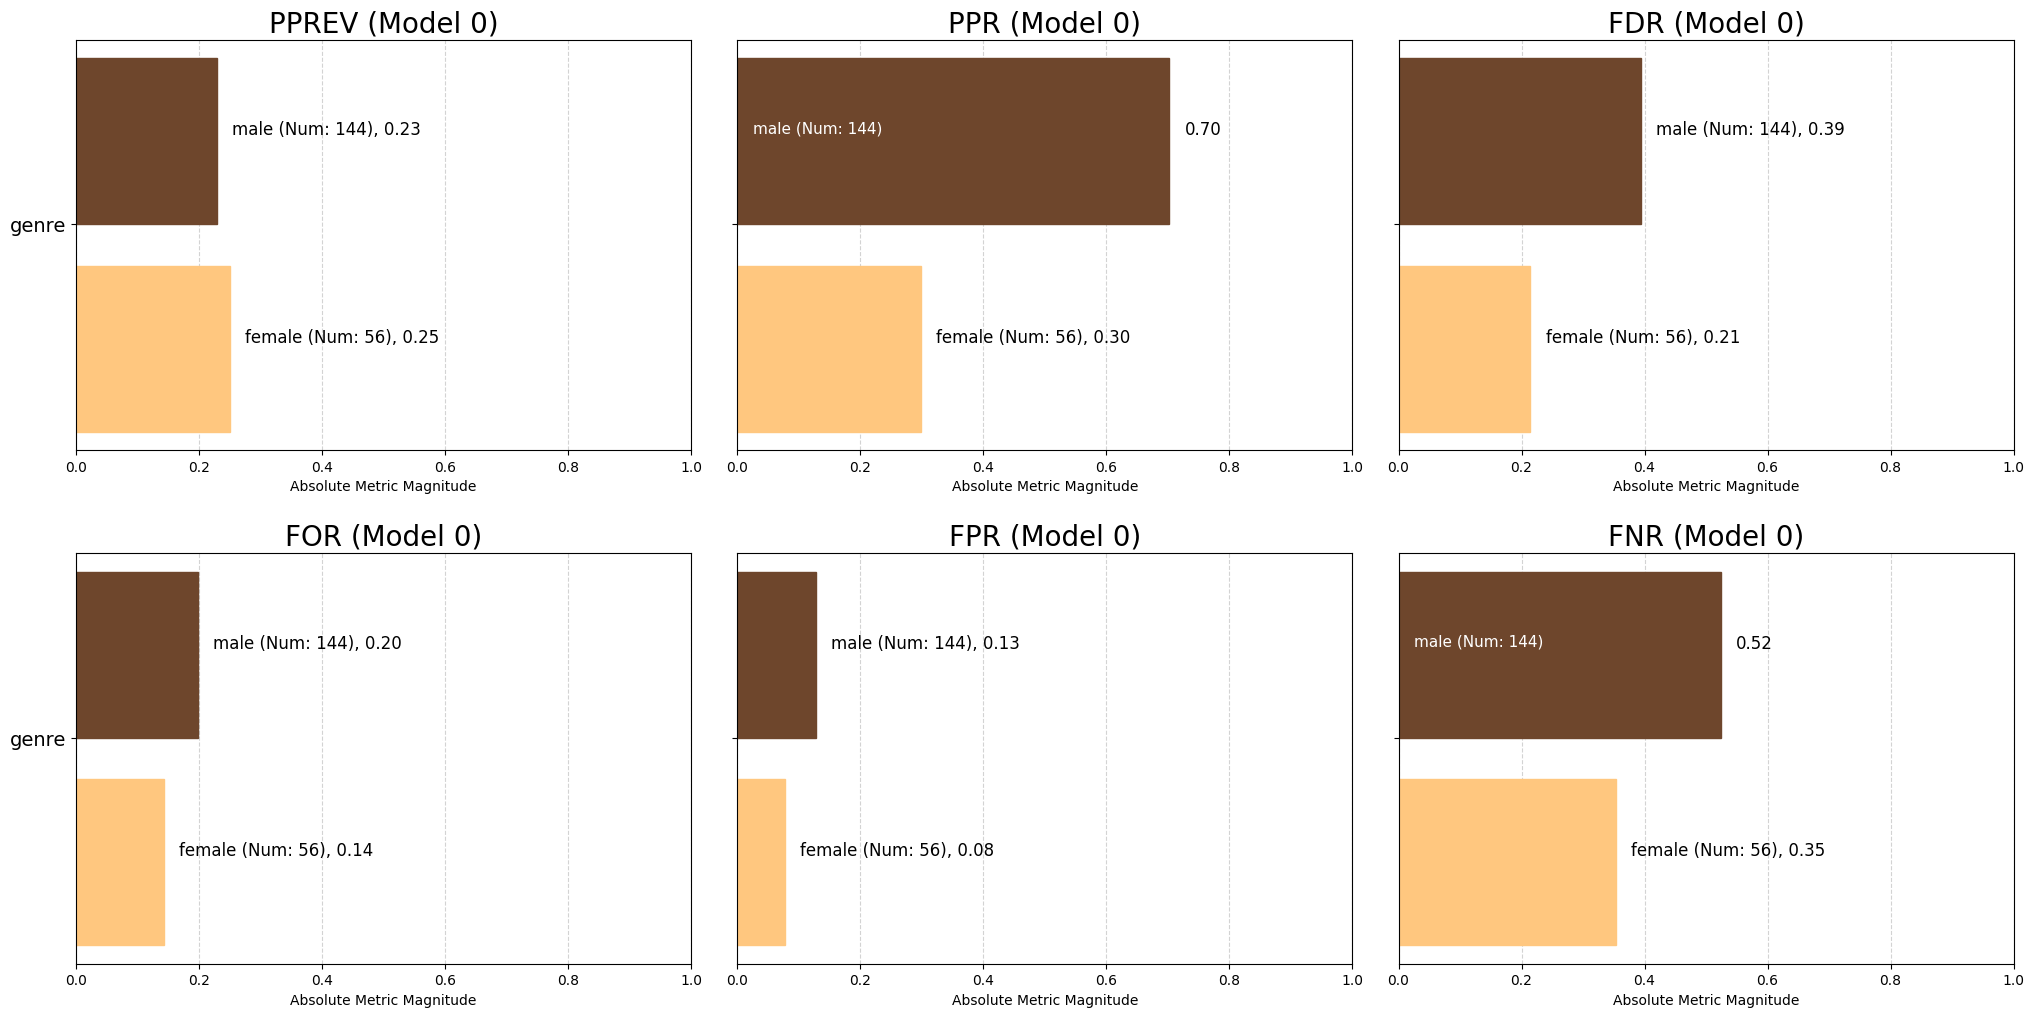

<Figure size 640x480 with 0 Axes>

In [ ]:
aqp = Plot()
a = aqp.plot_group_metric_all(xtab, ncols=3)
plt.tight_layout()

Este gráfico muestra la comparativa entre los grupos de algunas métricas absolutas, las consideradas por la librería como "default".

Podemos notar algo que vimos también en el resumen de clasificación en la sección anterior, y es que el modelo tuvo mejor desempeño en cada métrica para el grupo femenino a comparación del masculino. Un ejemplo es el False Negative Rate donde la diferencia es bastante pronunciada, siendo el grupo masculino el que cuenta con 0.52 de proporción y el grupo femenino solo con 0.35.

### Evaluando según distintos enfoques del Group Fairness

Desde el principio de este análisis hemos estado analizando el riesgo crediticio de un solicitante tomando como atributo protegido a la variable que registra el género del mismo, por lo tanto podemos considerar que estamos haciendo un análisis de equidad por grupos.

Justamente una de las ramas del Fairness en aprendizaje automático que ofrece formas de medir equidad en grupos es el "Group Fairness", el cual ofrece consigo 4 principales definiciones de lo que podríamos considerar como equidad según nuestro criterio:

* **Statistical Parity:** Evalúa si un modelo de clasificación selecciona o aprueba personas en igual proporción entre distintos grupos, sin importar si realmente cumplen o no con los criterios para ser seleccionados.

* **Equalized Odds**: Exige que el modelo cometa aciertos y errores con la misma frecuencia en todos los grupos. Es decir, quienes merecen ser clasificados positivamente deberían tener la misma probabilidad de serlo (true positive rate), y quienes no lo merecen deberían tener la misma probabilidad de ser incorrectamente clasificados como positivos (false positive rate), sin importar a qué grupo pertenezcan.

* **Equal Opportunity**: Se enfoca únicamente en los casos en los que las personas realmente merecen ser clasificadas como positivas (true positive rate), y exige que el modelo les dé las mismas oportunidades de ser seleccionadas, sin importar su grupo.

* **Predictive Parity**: Evalúa si, entre todos los que fueron clasificados como positivos por el modelo, la probabilidad de que realmente lo sean (es decir, que sí lo merecían) es la misma para todos los grupos. En otras palabras, si el modelo dice que una persona de cierto grupo merece un beneficio, esta métrica se asegura de que esa predicción tenga la misma fiabilidad que para alguien de otro grupo.


Normalmente al trabajar con Group Fairness elegimos la definición que más se adapte a nuestro caso y trabajamos con ella, pero a casos prácticos de este análisis vamos a hacer un análisis de Fairness considerando a las 4 definiciones.

Para eso vamos a utilizar otra clase que ofrece Aequitas la cual se llama "Bias" y sirve para estimar disparidades entre diferentes grupos en nuestros datos. Para calcular dichas disparidades usa como base las métricas que obtuvimos anteriormente usando la clase "Group" y luego calcula la disparidad correspondiente a cada métrica haciendo el siguiente cociente:

$$Disparidad_{métrica} = \frac{Métrica_{grupoA}}{Métrica_{grupoB}}$$

Donde "grupoB" sería ese grupo que consideramos como "base" y "grupoA" un grupo que nos interesa medir respecto del base. No está de más decir que si no hay disparidad entonces este cociente sea la métrica que sea debería ser casi igual a 1.

In [ ]:
b = Bias()
bias = b.get_disparity_predefined_groups(
    xtab,
    original_df=fairness_df_aequitas,
    ref_groups_dict={'genre': 'male'},
    alpha=0.05,
    mask_significance=True
)

f = Fairness()
fairness = f.get_group_value_fairness(bias)

En el código de arriba usamos "Bias" para calcular las diparidades y dicho resultado se añade a la 'xtab' que estabámos usando anteriormente. Además hacemos uso de una nueva clase "Fairness" que usa las disparidades para afirmar o no la inequidad entre los grupos.

A continuación vamos a ver la estructura del conjunto de datos "fairness" que obtuvimos:

In [ ]:
fairness

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,...,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,47,genre,female,0.839286,0.647059,0.923077,0.142857,0.214286,...,False,False,True,True,False,False,False,False,False,False
1,0,binary 0/1,47,genre,male,0.756944,0.476190,0.872549,0.198198,0.393939,...,True,True,True,True,True,True,True,True,True,True


Podemos ver que efectivamente es el mismo conjunto de datos que antes pero añadiendo al final los nuevos cálculos que ofrecen las clases "Fairness" y "Bias" respectivamente.

Como ahora nos estamos enfocando en las disparidades vamos a observar a las mismas en nuestro conjunto de datos:

In [ ]:
calculated_disparities = b.list_disparities(fairness)
fairness[['attribute_value'] + calculated_disparities]

,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,female,0.424242,1.090909,1.296429,0.543956,0.720779,0.60355,0.673797,1.358824,1.057908,1.069021
1,male,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


Podemos ver que para la clase base "male" la disparidad siempre da 1, tiene sentido ya que una clase siempre es similar a ella misma. Luego para la clase "female" vemos que los valores son diferentes en cada caso y estos representan las disparidades que queremos medir.

Normalmente lo que hacemos es definir un umbral de equidad y a partir de ahí decidir si una clase obtuvo clasificaciones justas o no, en ambos sentidos. Un valor habitual para este umbral puede ser 1.25, este lo que haría sería considerar injusto aquellos valores de disparidad en la clase de interés que estén por fuera del rango [1 - 0.25, 1 + 0.25].

Ahora para terminar este análisis de equidad por género vamos a utilizar todas estas métricas calculadas anteriormente y evaluar si nuestro modelo de clasificiación cumple con las definiciones de Fairness que discutimos al principio. Vamos a darle un sentido a cada definición según el contexto de nuestro caso y mirar mediante gráficos que ocurre en cada caso.

**Statistical Parity / Demographic Parity (Independencia): $\mathbb{P}(\hat{Y} = 1 | A =a) = \mathbb{P}(\hat{Y} = 1 | A =b)$**

En nuestro caso tenemos que la clase positiva es 1 = solicitante de alto riesgo crediticio. Tomando en cuenta eso podemos decir que Statistical Parity busca que la tasa de solicitantes clasificados **por el modelo** como de alto riesgo sea la misma para ambos géneros.

Una métrica que nos podría ayudar es 'pprev' que según la [documentación de Aequitas](https://dssg.github.io/aequitas/metrics.html) mide la proporción de instancias identificadas como positivas por el modelo (en nuestro caso solicitantes de alto riesgo) sobre el total de instancias para un grupo dado, lo cual justamente coincide con la definición de probabilidad condicional más arriba.

In [ ]:
metrics = ['pprev']

print('Evaluando Statistical Parity/Demographic Parity')
ap.summary(fairness, metrics, fairness_threshold = 1.25)

Evaluando Statistical Parity/Demographic Parity


alt.VConcatChart(...)

In [ ]:
ap.disparity(fairness, metrics, 'genre' ,fairness_threshold = 1.25)

alt.LayerChart(...)

**Equalized Odds (Separación): $\mathbb{P}(\hat{Y} = 1 |Y = 1, A =a) = \mathbb{P}(\hat{Y} = 1 |Y = 1, A =b)$ $\text{ y }$ $\mathbb{P}(\hat{Y} = 1 |Y = 0, A =a) = \mathbb{P}(\hat{Y} = 1 |Y = 0, A =b)$**

Para Equalized Odds tenemos que esta métrica busca que **el modelo** clasifique como solicitantes de alto riesgo correcta e incorrectamente a ambos géneros por igual. Esto implica que ambos grupos tendrían la misma probabilidad de recibir predicciones positivas (alto riesgo en nuestro caso) verdaderas y falsas.

**Equal Oportunity (Separación relajada): $\mathbb{P}(\hat{Y} = 1 |Y = 1, A =a) = \mathbb{P}(\hat{Y} = 1 |Y = 1, A =b)$**

Equal Oportunity es una versión "relajada" del caso anterior, esta solo busca que **el modelo** ofrezca la misma tasa de solicitantes clasificados como de alto riesgo **correctamente** para ambos géneros.

En este caso las métricas que nos van a ayudar son más claras, el True Positive Rate y el False Positive Rate. Para que se cumpla Equalized Odds ambas métricas deberían pasar la prueba de disparidad y para que se cumpla Equal Oportunity solo basta con que el true positive rate lo haga.

In [ ]:
metrics = ['tpr', 'fpr']

print('Evaluando Equalized Odds y Equal Opportunity')
ap.summary(fairness, metrics, fairness_threshold = 1.25)

Evaluando Equalized Odds y Equal Opportunity


alt.VConcatChart(...)

In [ ]:
ap.disparity(fairness, metrics, 'genre' ,fairness_threshold = 1.25)

alt.LayerChart(...)

**Predictive Parity (Suficiencia): $\mathbb{P}(Y= 1 |\hat{Y} =\hat{y}, A =a) = \mathbb{P}(Y= 1 |\hat{Y} =\hat{y}, A =b)$**  

Predictive Parity es una métrica que trabaja más sobre las clasificaciones reales. Para nuestro caso esta lo que busca es que ambos géneros tengan la misma probabilidad de que cuando fueron identificados como solicitantes de alto riesgo **por el modelo** estos realmente lo sean en la realidad.

Una métrica que nos sirve en este caso es la precisión, que lo que hace es que basándose en todas las predicciones del modelo mira cuáles fueron positivas (solicitantes de alto riesgo) realmente.

In [ ]:
metrics = ['precision']

print('Evaluando Predictive Parity')
ap.summary(fairness, metrics, fairness_threshold = 1.25)

Evaluando Predictive Parity


alt.VConcatChart(...)

In [ ]:
ap.disparity(fairness, metrics, 'genre' ,fairness_threshold = 1.25)

alt.LayerChart(...)

Tenemos que para un umbral de 1.25 de disparidad y tomando como categoría base al género masculino la única métrica que "pasó la prueba" fue Statistical Parity/Demographic Parity, luego el resto no lograron pasar esta prueba pero sin embargo hay varias cosas que podemos notar:

* El False Positive rate del género femenino dió mucho más bajo que el del género masculino, acercándose a casi 2 puntos de disparidad. Esto implica de que el modelo tiende a clasificar erronéamente como solicitante de alto riesgo mucho más al género masculino

* Hubo disparidad en cuanto a Predictive Parity y el True Positive Rate pero estas no fueron tan marcadas como en el caso anterior, si bien ambas pasaron el umbral de 1.25 esto no fue por mucho y lo podríamos considerar como algo positivo en cuanto a la equidad del clasificador.

En conclusión pudimos notar que nuestro clasificador muestra inequidades en la mayoría de las métricas de Group Fairness y eso nos deja saber que hay espacio para mejorar el mismo. Lo ideal en pasos posteriores de este análisis sería trabajar un nuevo clasificador pero haciendo foco en las métricas que mostraron mayor disparidad.